## Housing Price Prediction - Assignment Solution

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation


### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# reading the dataset
house = pd.read_csv("https://cdn.upgrad.com/UpGrad/temp/9cefd607-bbb7-443d-bb3e-eac9fef04453/train.csv",sep=',')

In [3]:
print(house.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
# head
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Understanding the Data Dictionary

The data dictionary contains the meaning of various attribute

In [5]:
house['Utilities'].astype('category').value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [6]:
house['Street'].astype('category').value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [7]:
house['Neighborhood'].astype('category').value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

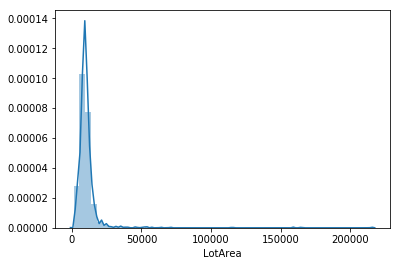

In [8]:
sns.distplot(house['LotArea'])
plt.show()

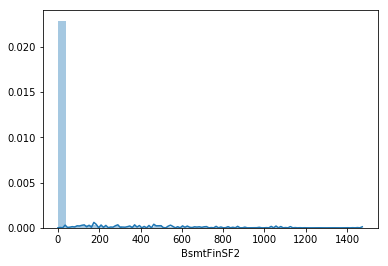

In [9]:
sns.distplot(house['BsmtFinSF2'])
plt.show()

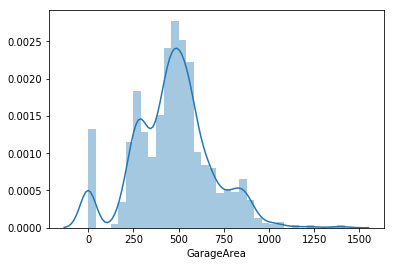

In [10]:
sns.distplot(house['GarageArea'])
plt.show()

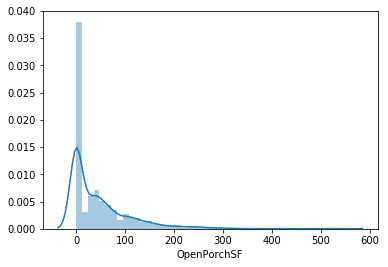

In [11]:
sns.distplot(house['OpenPorchSF'])
plt.show()

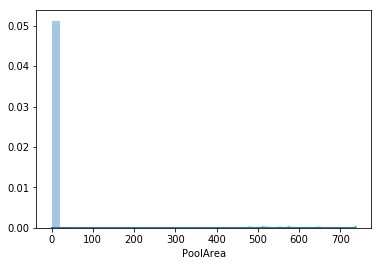

In [12]:
sns.distplot(house['PoolArea'])
plt.show()

#### Data Exploration

To perform linear regression, the (numeric) target variable should be linearly related to *at least one another numeric variable*. Let's see whether that's true in this case.


We'll first subset the list of all (independent) numeric variables, and then make a **pairwise plot**.

In [13]:
# all numeric (float and int) variables in the dataset
house_numeric = house.select_dtypes(include=['float64', 'int64'])
house_numeric.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


This is quite hard to read, and we can rather plot correlations between variables. Also, a heatmap is pretty useful to visualise multiple correlations in one plot.

In [14]:
# correlation matrix
cor = house_numeric.corr()
cor

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


## 2. Data Cleaning

Let's now conduct some data cleaning steps. 


In [15]:
# variable formats
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [16]:
house['Alley'] = house['Alley'].fillna('No alley access')
house['BsmtQual'] = house['BsmtQual'].fillna('No Basement')
house['BsmtCond'] = house['BsmtCond'].fillna('No Basement')
house['BsmtExposure'] = house['BsmtExposure'].fillna('No Basement')
house['BsmtFinType1'] = house['BsmtFinType1'].fillna('No Basement')
house['BsmtFinType2'] = house['BsmtFinType2'].fillna('No Basement')
house['FireplaceQu'] = house['FireplaceQu'].fillna('No Fireplace')
house['GarageType'] = house['GarageType'].fillna('No Garage')
house['GarageFinish'] = house['GarageFinish'].fillna('No Garage')
house['GarageQual'] = house['GarageQual'].fillna('No Garage')
house['GarageCond'] = house['GarageCond'].fillna('No Garage')
house['PoolQC'] = house['PoolQC'].fillna('No Pool')
house['Fence'] = house['Fence'].fillna('No Fence')
house['MiscFeature'] = house['MiscFeature'].fillna('None')

In [17]:
# outliers
house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [18]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non

In [19]:
# Write your code for column-wise null percentages here
a=round(100*(house.isnull().sum()/len(house.index)),2).rename('percentage').reset_index()
b=a.loc[a.percentage>0]
b.sort_values(by='percentage',ascending=False,inplace=True)
b

,index,percentage
3,LotFrontage,17.74
59,GarageYrBlt,5.55
25,MasVnrType,0.55
26,MasVnrArea,0.55
42,Electrical,0.07


In [20]:
house = house.fillna(house.mean())

In [21]:
# Write your code for column-wise null percentages here
a=round(100*(house.isnull().sum()/len(house.index)),2).rename('percentage').reset_index()
b=a.loc[a.percentage>0]
b.sort_values(by='percentage',ascending=False,inplace=True)
b

,index,percentage
25,MasVnrType,0.55
42,Electrical,0.07


In [22]:
house1 = house.dropna()

In [23]:
# Write your code for column-wise null percentages here
a=round(100*(house1.isnull().sum()/len(house1.index)),2).rename('percentage').reset_index()
b=a.loc[a.percentage>0]
b.sort_values(by='percentage',ascending=False,inplace=True)
b

,index,percentage


Null values are handled now

In [24]:
# Cheking for duplicates in df
duplicatehouse = house1[house1.duplicated()]

In [25]:
duplicatehouse

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


# environment settings: 
pd.set_option('display.max_column',None)

## 3. Data Preparation 


#### Data Preparation

Let's now prepare the data and build the model.

In [26]:
house1.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [27]:
# split into X and y
X = house1.loc[:, ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']]

y = house1['SalePrice']


In [28]:
# creating dummy variables for categorical variables

# subset all categorical variables
house_categorical = X.select_dtypes(include=['object'])
house_categorical.head()


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,No alley access,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,No Pool,No Fence,None,WD,Normal
1,RL,Pave,No alley access,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,No Pool,No Fence,None,WD,Normal
2,RL,Pave,No alley access,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,No Pool,No Fence,None,WD,Normal
3,RL,Pave,No alley access,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,No Pool,No Fence,None,WD,Abnorml
4,RL,Pave,No alley access,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,No Pool,No Fence,None,WD,Normal


In [29]:
# convert into dummies
house_dummies = pd.get_dummies(house_categorical, drop_first=True)
house_dummies.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_No alley access,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [30]:
# drop categorical variables 
X = X.drop(list(house_categorical.columns), axis=1)

In [31]:
# concat dummy variables with X
X = pd.concat([X, house_dummies], axis=1)

In [32]:
# scaling the features
from sklearn.preprocessing import scale

# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=260)

In [33]:
# split into train and test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## 3. Model Building and Evaluation

## Ridge and Lasso Regression

Let's now try predicting car prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

## Ridge Regression

In [34]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    3.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [35]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=1000]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.024201,0.002926,0.0012,0.0004,0.0001,{'alpha': 0.0001},-24712.660767,-13872.045379,-20695.411389,-21972.700628,...,-20209.372593,3576.573143,28,-11314.372118,-12032.456570,-11363.860661,-11636.385669,-10653.946913,-11400.204386,451.909877
1,0.022401,0.001497,0.0012,0.0004,0.001,{'alpha': 0.001},-24712.444345,-13865.476206,-20636.422533,-21926.255649,...,-20189.075900,3572.516492,27,-11314.384797,-12034.752065,-11366.428038,-11637.197313,-10655.779069,-11401.708256,451.991149
2,0.023001,0.002191,0.0012,0.0004,0.01,{'alpha': 0.01},-24710.283334,-13810.098860,-20113.338978,-21498.082821,...,-20006.054605,3543.130489,26,-11314.511569,-12056.500605,-11389.786400,-11645.469706,-10671.873214,-11415.628299,453.344992
3,0.026602,0.004128,0.0012,0.0004,0.05,{'alpha': 0.05},-24700.750815,-13679.795668,-18686.835051,-20087.634834,...,-19464.896767,3531.888020,9,-11315.102707,-12131.481962,-11460.820462,-11701.041820,-10729.197570,-11467.528904,461.253477
4,0.025201,0.002561,0.0012,0.0004,0.1,{'alpha': 0.1},-24689.010531,-13639.513450,-17805.573238,-18990.213854,...,-19090.211773,3584.577432,3,-11315.907952,-12189.221861,-11513.754022,-11758.401266,-10776.700157,-11510.797052,468.712454


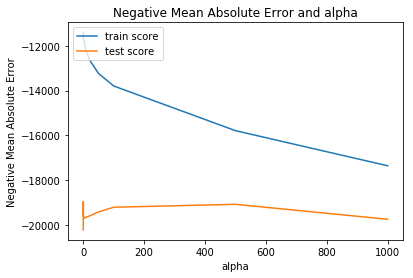

In [36]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [37]:
alpha = 100
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([-1.16496220e+02, -3.01890505e+03, -5.48297801e+02,  5.85208259e+03,
        1.12702818e+04,  4.86185144e+03,  2.35189291e+03,  1.86217664e+03,
        4.26280101e+03,  3.23131637e+03,  5.54094351e+02, -8.51625742e+01,
        3.47881161e+03,  6.89334921e+03,  7.67738648e+03, -1.24489803e+03,
        1.13048064e+04,  2.22788468e+03, -1.38188501e+03,  3.37401664e+03,
        2.30498642e+03, -1.14461770e+03, -3.33886704e+03,  5.13545229e+03,
        3.08140005e+03,  1.56130651e+03,  6.94580280e+03,  8.88186535e+02,
        2.33656607e+03,  8.83506128e+02,  3.24948504e+02,  1.25570322e+03,
        1.74610479e+03,  9.21226735e+03,  1.92398619e+02,  5.51164672e+02,
       -3.29709114e+02,  1.63577886e+03,  9.18020690e+02,  2.25167102e+03,
       -6.15444695e+01,  2.21869758e+03, -4.12077077e+02,  2.96347341e+02,
        1.05643474e+03, -1.67987363e+03, -7.06092297e+02,  2.66199552e+03,
        2.48354171e+02,  2.86219157e+03, -7.96920669e+02,  2.05427500e+03,
       -1.32082389e+03, -

## Lasso

In [38]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:   33.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [39]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.301417,0.029386,0.0010,9.536743e-08,0.0001,{'alpha': 0.0001},-24716.158698,-13766.473149,-19440.920396,-19327.370118,...,-19587.501147,3506.697336,28,-11314.139145,-12344.525797,-11665.109950,-11939.398345,-10908.736923,-11634.382032,495.459313
1,0.435025,0.070901,0.0012,4.000187e-04,0.001,{'alpha': 0.001},-24716.094202,-13766.451452,-19440.774341,-19327.420568,...,-19587.449872,3506.681473,27,-11314.136589,-12344.522122,-11665.105418,-11939.396052,-10908.733557,-11634.378748,495.459237
2,0.340820,0.055068,0.0006,4.899014e-04,0.01,{'alpha': 0.01},-24715.449517,-13766.234468,-19439.313813,-19327.925265,...,-19586.937260,3506.522990,26,-11314.119632,-12344.485529,-11665.061124,-11939.375873,-10908.702268,-11634.348885,495.457071
3,0.297217,0.031659,0.0004,4.899792e-04,0.05,{'alpha': 0.05},-24712.570179,-13765.269956,-19432.846046,-19330.153205,...,-19584.658358,3505.816100,25,-11314.051718,-12344.329255,-11664.868646,-11939.281987,-10908.577873,-11634.221896,495.443546
4,0.250214,0.014359,0.0004,4.899208e-04,0.1,{'alpha': 0.1},-24708.995630,-13764.064157,-19424.755675,-19332.949065,...,-19581.816957,3504.943131,24,-11313.963652,-12344.141837,-11664.633805,-11939.198662,-10908.445228,-11634.076637,495.426895


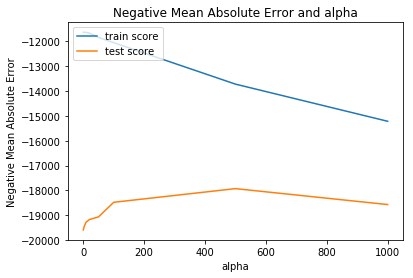

In [40]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [41]:
alpha =500

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=500, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [42]:
lasso.coef_

array([-0.00000000e+00, -4.93521082e+03, -0.00000000e+00,  4.77137661e+03,
        1.45506808e+04,  5.56830195e+03,  3.64051530e+03,  1.51471774e+03,
        3.86490152e+03,  4.27059492e+03,  0.00000000e+00, -0.00000000e+00,
        3.65296134e+03,  5.72790623e+02,  0.00000000e+00, -1.58616696e+03,
        2.72438040e+04,  2.32289341e+03, -7.98516021e+02,  5.55989267e+02,
        4.48666526e+02, -1.05910491e+03, -3.27525505e+03,  2.19930412e+03,
        1.27113332e+03,  2.32804656e+03,  6.93201636e+03,  0.00000000e+00,
        1.87018571e+03,  8.80703714e+02, -0.00000000e+00,  6.35655331e+02,
        1.20454455e+03,  3.38590898e+04, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  3.52197549e+02,  0.00000000e+00,  0.00000000e+00,
       -1.88429427e+03,  1.46374371e+03, -0.00000000e+00,  0.00000000e+00,
        5.74481059e+02, -1.00179163e+03, -3.75231579e+02,  1.38746180e+03,
       -0.00000000e+00,  1.00192599e+03, -5.95146390e+02,  2.13357581e+03,
       -3.44631746e+02, -